<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#implmentation" data-toc-modified-id="implmentation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>implmentation</a></span><ul class="toc-item"><li><span><a href="#QuadraticSplineRegression" data-toc-modified-id="QuadraticSplineRegression-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>QuadraticSplineRegression</a></span></li><li><span><a href="#NestingRegression" data-toc-modified-id="NestingRegression-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>NestingRegression</a></span></li></ul></li><li><span><a href="#1D" data-toc-modified-id="1D-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>1D</a></span><ul class="toc-item"><li><span><a href="#1-knot" data-toc-modified-id="1-knot-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>1 knot</a></span></li><li><span><a href="#2-knots" data-toc-modified-id="2-knots-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>2 knots</a></span></li><li><span><a href="#3-knots" data-toc-modified-id="3-knots-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>3 knots</a></span></li><li><span><a href="#$\exp(x\cos(3\pi-x))$" data-toc-modified-id="$\exp(x\cos(3\pi-x))$-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>$\exp(x\cos(3\pi x))$</a></span></li></ul></li><li><span><a href="#2D-fit" data-toc-modified-id="2D-fit-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>2D fit</a></span><ul class="toc-item"><li><span><a href="#1-knot" data-toc-modified-id="1-knot-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>1 knot</a></span></li><li><span><a href="#2x2-knots" data-toc-modified-id="2x2-knots-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>2x2 knots</a></span><ul class="toc-item"><li><span><a href="#first-four-basis" data-toc-modified-id="first-four-basis-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>first four basis</a></span></li></ul></li></ul></li><li><span><a href="#5D-fit-on-grid-vs.-random-locations" data-toc-modified-id="5D-fit-on-grid-vs.-random-locations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>5D fit on grid vs. random locations</a></span></li><li><span><a href="#嵌套插值回归" data-toc-modified-id="嵌套插值回归-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>嵌套插值回归</a></span></li><li><span><a href="#Benchmark" data-toc-modified-id="Benchmark-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Benchmark</a></span></li></ul></div>

# implmentation

## QuadraticSplineRegression

In [1]:
import numpy as np

class QuadraticSplineRegression:
    
    def __init__(self, knots, alpha=None):
        if alpha is None:
            alpha = 1E-6
        self.alpha = alpha
        
        assert knots is not None
            
        all_is_scalar=True
        all_is_list=True
        for item in knots:
            all_is_scalar = all_is_scalar and np.isscalar(item)
            all_is_list = all_is_list and np.ndim(item) == 1
            
        if all_is_scalar:
            if len(knots) < 1:
                raise Exception("At lease one knot")
            knots = np.array(knots).reshape(1,-1)
        elif all_is_list:
            pass
        else:
            raise Exception('''1d array or 2d array knots needed, format: [xi0, xi1, ...] or \
                [[xi00, xi01, ...],\
                [xi10, xi11, ..],\
                ...]''')
        
        self.knots = knots
        
        
        # h0(x) = 1
        # h1(x) = x     
        # if N_hnots >= 2
            # i >= 0 && i+1 <= N_hnots-1
            # h(2+i)(x) = (x-xi_i)_+^2+ - (x-xi_(i+1))_+^2
            # h(2+i)(x) = 0,  x <  x_i
            #             (x-xi_i)^2,   xi_i < x < xi_i+1
            #             (x_(i+1)-x_i)(2x - x_i - xi_(i+1)), xi_i+1 < x
        self.N_splines = QuadraticSplineRegression.cal_N_splines(knots)
        #print("splines%d:", self.N_splines)
        
    @staticmethod
    def cal_N_splines(knots):
        N_splines = 1
        for knots_1D in knots:
            N_knots_1D = len(knots_1D)
            assert N_knots_1D >= 1            
            N_splines_1D = N_knots_1D + 1
            N_splines *= N_splines_1D
        
        return N_splines
    
    def get_H(self, X):
        knots = self.knots
        Ndata = X.shape[0]
        assert Ndata > 0
        
        N_splines = self.N_splines
        
        #print("N_splines", N_splines)
        #print("Ndata", Ndata)
                
        H = np.ones((N_splines, Ndata))
        
        dim_in = 1
        for d in range(X.shape[1]):
            x = X[:, d]
            knots_1D = knots[d]
            N_knots_1D = len(knots_1D)
            assert N_knots_1D >= 1
            
            N_splines_1D = N_knots_1D + 1
            
            h = np.zeros((N_splines_1D, Ndata))

            #print("knots_1D:", knots_1D)
            #print("N_splines_1D:", N_splines_1D)
            knots_1D = np.sort(knots_1D)
            xi_max = np.max(knots_1D)
            
            h[0,:] = 1
            h[1,:] = x
            for i in range(2, N_splines_1D):
                xi = knots_1D[i-2]
                xiplus1 = knots_1D[i-1]
                h[i, :] = np.where(x < xi, 0.0,\
                                np.where(x < xiplus1,  (x-xi)**2, (xiplus1-xi)*(2*x - xi - xiplus1)  )) 
                assert xiplus1 - xi > 0
                assert 2*xi_max - xi - xiplus1 > 0
                h[i, :] /= (xiplus1 - xi)*(2*xi_max - xi - xiplus1)
                    
            # H[i][j][k] = h1[i]h2[j]h3[k]
            # H[i*JK + j*K + k] = h1[i]h2[j]h3[k]
            # H[i*JK+ j*stride + offset] = ... h2[j]...            
            dim_out =  N_splines//N_splines_1D//dim_in
            #print("d", d)
            #print("N_splines", N_splines)
            #print("dim_in", dim_in)
            #print("N_splines_1D", N_splines_1D)
            H = np.reshape(H, (dim_out, N_splines_1D, dim_in, Ndata))
            H[:,:,:,:] *= h[:,np.newaxis,:]
                
            dim_in *= N_splines_1D
            
        H = H.reshape(-1, Ndata).transpose()
        return H
    
        
    def fit(self, X, y):
        alpha = self.alpha
        knots = self.knots
        #print("fit X:", X)
        #print("fit X shape", X.shape)
        
        X = np.array(X, dtype=np.float_)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        elif X.ndim != 2:
            raise Exception("data format incorrect")
            
        # no data
        if X.shape[0] == 0:
            raise Exception("no data to train!\n")
            
        if np.shape(knots)[0] != X.shape[1]:
            raise Exception("dimension of knots not match data's! knots dim = %d != X shpae[1]  = %d"%(np.shape(knots)[0], X.shape[1]))
        
            
        y = np.array(y, dtype=np.float_)
        assert np.ndim(y) == 1
        
        Ndata = np.shape(X)[0] 
        H = self.get_H(X)
        
        # remove bias term        
        # we will handle it by ourselves
        H =  H[:, 1:]
        
        # center data
        H_mean = np.mean(H, axis=0)
        H -= H_mean

        # needed for L2 regularization
        # but this don't work
        #H_scale = 1/np.sqrt(H.var(axis=0))
        #H = H_scale*H        
        #self.H_scale = H_scale
        
        
        # H[:,0] is special, no L2 applied on it
        
        # now we fit
        #   sum_j (y_j - sum_i H_i(X_j) beta_i)^2 + alpha sum_i beta_i^2
        #   U S VT = H_i
        #   beta_i = V (alpha*I + S^T S)^-1 S^T U y
        
        U,D,VT = np.linalg.svd(H, full_matrices=False)
        lamb = alpha*Ndata
        invD = D/(np.square(D) + lamb)      
        
        self.VT = VT
        self.invD = invD
        self.U = U
        self.H_mean = H_mean
        
        self.update_for_y(y)
        
    def update_for_y(self, y):
        VT = self.VT
        U = self.U
        invD = self.invD
        H_mean = self.H_mean

        y_mean = np.mean(y)
        y -= y_mean
    
        beta = VT.T.dot((invD * U.T.dot(y)))        
        # bias calculate here, not by ridge linear regression
        self.bias = y_mean - H_mean.dot(beta)
        self.beta = beta
        
        
    def predict(self, X):
        knots = self.knots
        
        X = np.array(X, dtype=np.float_)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        elif X.ndim != 2:
            raise Exception("data format incorrect")
            
        # no data
        if X.shape[0] == 0:
            return np.array([])
        
        #print("predict shape ", X.shape)
        #print("predict X", X)
        
        if np.shape(knots)[0] != X.shape[1]:
            raise Exception("dimension of knots not match data's! knots dim = %d != X shpae[1]  = %d"%(np.shape(knots)[0], X.shape[1]))
        
            
        
        #   y = sum_i H_i(x) beta_i + b
        H = self.get_H(X)
        # we don't need first constant basis, we have bias ourselves
        H =  H[:, 1:]
        yhat = H.dot(self.beta) + self.bias
        return yhat
    
    
    


## NestingRegression

In [2]:
import numpy as np
class NestingRegression:
    
    
    def __init__(self, regs):        
        self.regs = regs
        
        # just check if it's iterable
        for i in range(len(regs)):
            regs[i]
    
        self.first_fit = [True]*len(regs)
        
    # X must be special order
    # so that we needn't group
    # we just tick out column one by one
    def fit(self, X, y):
        self.X = X
        self.y = y
        
        
    def predict(self, X):
        regs =  self.regs
        X_to_predict = X
        N_to_predict = np.shape(X_to_predict)[0]
        
        y_result = np.zeros(N_to_predict)
        
        for xi, x_to_predict in enumerate(X_to_predict):

            X = self.X
            y = np.copy(self.y)

            # how many columns
            Nd = np.shape(X)[1]
            for d_ in range(Nd):
                reg = regs[Nd - d_ - 1]

                # full last column
                last_col_of_X = X[:,-1]
                stride = len(np.unique(last_col_of_X))     
                iters = len(last_col_of_X)//stride

                # select one row in each `stride` rows
                #print(X)
                X = X[::stride]
                #print("stride:", stride)

                # last value
                last_value_of_x_to_predict = x_to_predict[-1]

                # remove last value from X 
                x_to_predict = x_to_predict[0:-1:1]
                X = X[:,:-1]
                #print("after remove last col, X:", X)
                #print("last_col_of_X", last_col_of_X)
                
                for i in range(iters):
                    # calculate y for each row of X 

                    # a segement
                    last_col_of_x = last_col_of_X[i*stride:(i+1)*stride:1]
                    
                    if self.first_fit[d_]:
                        reg.fit(last_col_of_x, y[i*stride:(i+1)*stride:1])
                        self.first_fit[d_] = False
                    else:
                        reg.update_for_y(y[i*stride:(i+1)*stride:1])             
                        
                    y_predict = reg.predict([last_value_of_x_to_predict])     
                    # reuse front of memory of y
                    y[i] = y_predict[0]

                    
                    
                y_result[xi] = y[0]
        
        return y_result
            
            
            
        
    

# 1D

## 1 knot

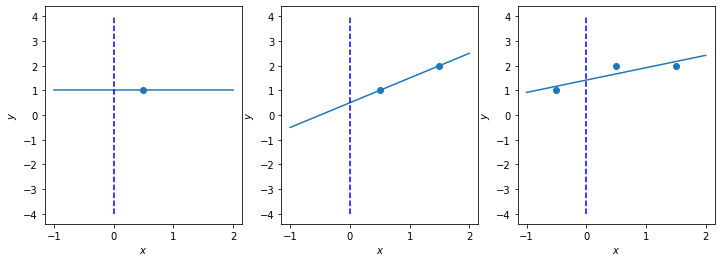

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def fit_plot(X_train, y_train, knots, xlim, ax):    
    X_plt = np.linspace(xlim[0], xlim[1], 100)
    reg = QuadraticSplineRegression(knots=knots)
    reg.fit(X_train, y_train)
    ax.scatter(X_train, y_train)
    ax.plot(X_plt, reg.predict(X_plt))
    #print(reg.beta)
    #print(reg.bias)
    for knot in knots:
        ax.plot([knot, knot],[-4,4], linestyle="--", color="blue")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    
    
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))
fit_plot(X_train = [0.5], y_train = [1], xlim=(-1,2), knots=[0], ax=ax1)
fit_plot(X_train = [0.5, 1.5], y_train = [1,2], xlim=(-1,2), knots=[0], ax=ax2)
fit_plot(X_train = [-0.5, 0.5, 1.5], y_train = [1,2,2], xlim=(-1,2), knots=[0], ax=ax3)
plt.show()

## 2 knots

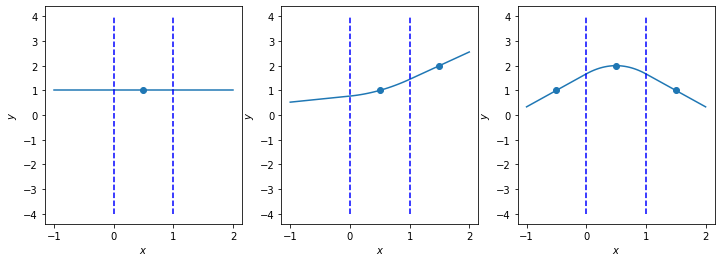

In [4]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))
fit_plot(X_train = [0.5], y_train = [1], xlim=(-1,2), knots=[0,1], ax=ax1)
fit_plot(X_train = [0.5, 1.5], y_train = [1,2], xlim=(-1,2), knots=[0,1],ax=ax2)
fit_plot(X_train = [-0.5, 0.5, 1.5], y_train = [1,2,1], xlim=(-1,2), knots=[0,1],ax=ax3)
plt.show()

## 3 knots

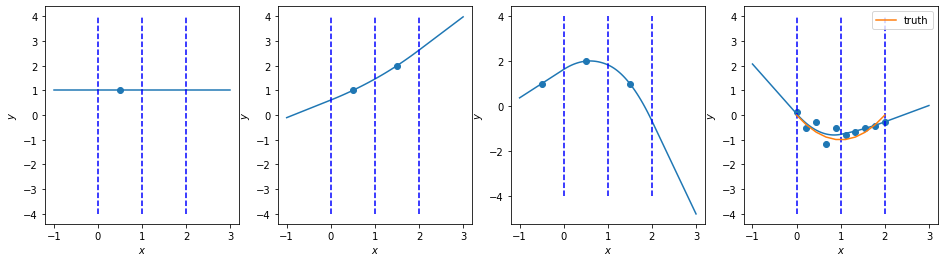

In [5]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(16,4))
fit_plot(X_train = [0.5], y_train = [1], xlim=(-1,3), knots=[0,1,2], ax=ax1)
fit_plot(X_train = [0.5, 1.5], y_train = [1,2], xlim=(-1,3), knots=[0,1,2],ax=ax2)
fit_plot(X_train = [-0.5, 0.5, 1.5], y_train = [1,2,1], xlim=(-1,3), knots=[0,1,2],ax=ax3)
X=np.linspace(0,2,10)
y=X*X-2*X
fit_plot(X_train = X, y_train=y+0.2*np.random.randn(10), xlim=(-1,3), knots=[0,1,2],ax=ax4)
ax4.plot(X, y, label="truth")
plt.legend(loc="upper right")
plt.show()

## $\exp(x\cos(3\pi x))$

这里回归退化成了差值。
这里的结果(0.004)比高斯核心的插值方法的结果（0.027）好大概一个数量级。
(see https://en.wikipedia.org/wiki/Radial_basis_function_interpolation)

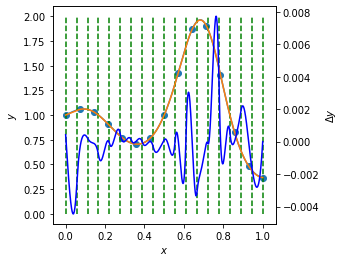

In [6]:
def f(X):
    return np.exp(X*np.cos(3*np.pi*X))
    
X_plt = np.linspace(0,1,1000)
X_train = np.linspace(0,1,15)

plt.figure(figsize=(4,4))
plt.plot(X_plt, f(X_plt), label="truth")
plt.scatter(X_train, f(X_train))

qsr=QuadraticSplineRegression(knots=np.linspace(0, 1.0, 19), alpha=1E-6)

for k in qsr.knots[0]:
    plt.plot([k,k], [0,2], linestyle="--", color="green")
    
qsr.fit(X_train, f(X_train))
plt.plot(X_plt, qsr.predict(X_plt), label="QuadraticSplineRegression")
plt.ylabel(r"$y$")
plt.xlabel("$x$")

plt.sca(plt.gca().twinx())
plt.plot(X_plt, qsr.predict(X_plt) - f(X_plt), color="blue", label="diff")
plt.ylabel(r"$\Delta y$")
#plt.legend()
plt.show()


# 2D fit

## 1 knot

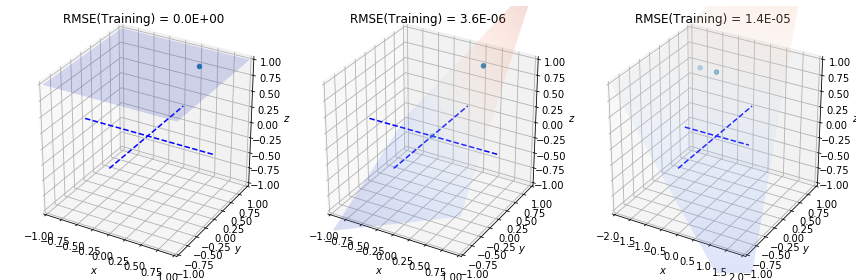

In [18]:
from mpl_toolkits.mplot3d.axes3d import get_test_data

def fit_plot3d_reg(X_train, y_train, knots, reg, X_test = None, y_test = None,\
                   xlim=(-1,1), ylim=(-1,1), zlim=(-1,1), ax=None, sz=20):
    reg.fit(X_train, y_train)
    
    
    X_train = np.array(X_train)
    
    x_plt = np.linspace(xlim[0], xlim[1], 100)
    y_plt = np.linspace(ylim[0], ylim[1], 100)
    xx, yy = np.meshgrid(x_plt, y_plt)
    #print(reg.beta)
    #print(reg.bias)
    #print(X_train[:,0])
    #print(X_train[:,1])
    #print(y_train)
    ax.scatter(X_train[:,0], X_train[:,1], y_train, s=sz)
    
    from matplotlib import cm
    ax.plot_surface(xx, yy, reg.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(100,100), alpha=0.2, cmap=cm.coolwarm)
    
    for k1 in knots[0]:
        ax.plot([k1, k1],[-1,1],[0,0], linestyle="--", color="blue")
    for k2 in knots[1]:
        ax.plot([-1, 1],[k2, k2],[0,0], linestyle="--", color="blue")
        
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_zlabel("$z$")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    mse = np.sqrt(np.square(y_train-reg.predict(X_train)).mean())
    if X_test is not None and X_test is not None:
        mse2 = np.sqrt(np.square(y_test-reg.predict(X_test)).mean())
        ax.set_title("RMSE(Training) = %.1E,\nRMSE(Test) = %.1E"%(mse, mse2))
    else:
        ax.set_title("RMSE(Training) = %.1E"%(mse))
    
    return reg

def fit_plot3d_qsr(X_train, y_train, knots, X_test=None, y_test=None, xlim=(-1,1), ylim=(-1,1), zlim=(-1,1), ax=None, sz=20, alpha=None):    
    reg = QuadraticSplineRegression(knots=knots, alpha=alpha)
    return fit_plot3d_reg(X_train, y_train, knots, reg, X_test=X_test, y_test = y_test, xlim=xlim, ylim=ylim, zlim=zlim, ax=ax, sz=sz)




    
fig=plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,3,1, projection="3d")
fit_plot3d_qsr(X_train = [[1/2,1/2]], y_train = [1], xlim=(-1,1), knots=[[0],[0]], ax=ax1)
ax2 = fig.add_subplot(1,3,2, projection="3d")
fit_plot3d_qsr(X_train = [[0,0], [1/2,1/2]], y_train = [0, 1], xlim=(-1,1), knots=[[0],[0]], ax=ax2)
ax3 = fig.add_subplot(1,3,3, projection="3d")
fit_plot3d_qsr(X_train = [[-1/2,0], [0,0], [1/2,1/2]], y_train = [1, 1, 2], xlim=(-2,2), knots=[[0],[0]], ax=ax3)
plt.tight_layout()
plt.show()


## 2x2 knots

### first four basis

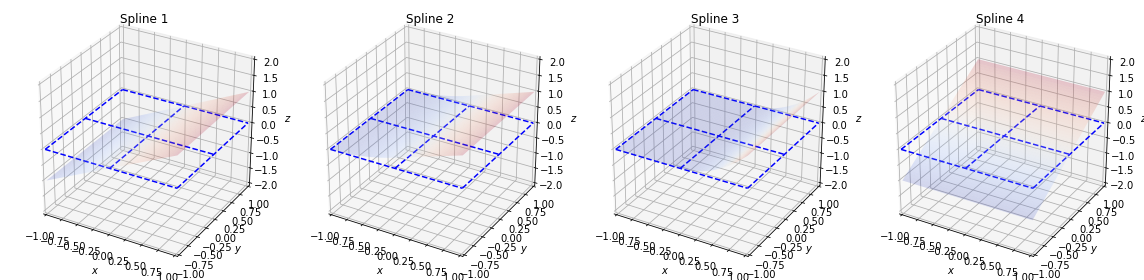

In [8]:
def fit_plot3d_i(knots, i, xlim=(-1,1), ylim=(-1,1), zlim=(-1,1), ax=None, sz=20, alpha=None):    
    
    x_plt = np.linspace(xlim[0], xlim[1], 100)
    y_plt = np.linspace(ylim[0], ylim[1], 100)
    xx, yy = np.meshgrid(x_plt, y_plt)
    reg = QuadraticSplineRegression(knots=knots, alpha=alpha)
    #beta = reg.beta[i]
    reg.beta = np.zeros(reg.N_splines-1)
    reg.beta[i] = 1
    reg.bias=0
    #print(reg.beta)
    #print(reg.bias)
    
    from matplotlib import cm
    ax.plot_surface(xx, yy, reg.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(100,100), alpha=0.2, cmap=cm.coolwarm)
    
    for k1 in knots[0]:
        ax.plot([k1, k1],[-1,1],[0,0], linestyle="--", color="blue")
    for k2 in knots[1]:
        ax.plot([-1, 1],[k2, k2],[0,0], linestyle="--", color="blue")
        
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_zlabel("$z$")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    ax.set_title("Spline %d"%(i+1))
    
    return reg



fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1,4,1, projection="3d")
reg = fit_plot3d_i(i=0, zlim=(-2,2), knots=[np.linspace(-1,1,3)]*2, ax=ax1, sz=10)
ax2 = fig.add_subplot(1,4,2, projection="3d")
reg = fit_plot3d_i(i=1,  zlim=(-2,2), knots=[np.linspace(-1,1,3)]*2, ax=ax2, sz=10)
ax3 = fig.add_subplot(1,4,3, projection="3d")
reg = fit_plot3d_i(i=2, zlim=(-2,2), knots=[np.linspace(-1,1,3)]*2, ax=ax3, sz=10)
ax4 = fig.add_subplot(1,4,4, projection="3d")
reg = fit_plot3d_i(i=3, zlim=(-2,2), knots=[np.linspace(-1,1,3)]*2, ax=ax4, sz=10)
plt.tight_layout()
plt.show()


[[-1.         -1.        ]
 [-1.         -0.77777778]
 [-1.         -0.55555556]
 ...
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]


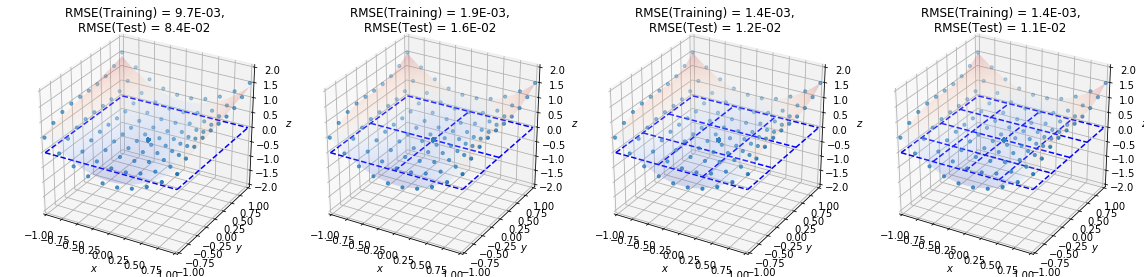

In [9]:
def f21(X):
    return X[:,0]*X[:,0] + 1/2*X[:,1]**3 + 0*np.random.randn(X.shape[0])



Ndata=100*100
N=2
N_grid=10

X_rnd=2*np.random.rand(Ndata,N)-1

X_grid=np.zeros((Ndata, N))
c=0

x1=np.linspace(-1,1,N_grid)
x2=np.linspace(-1,1,N_grid)

for i in range(N_grid):
    for j in range(N_grid):
        X_grid[c,0] = x1[i]
        X_grid[c,1] = x1[j]
        c += 1

X_train = X_grid     
y_train = f21(X_train)
X_test = X_rnd
y_test = f21(X_test)


fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1,4,1, projection="3d")
reg = fit_plot3d_qsr(X_train = X_train, y_train = y_train, X_test=X_test, y_test=y_test,\
                     zlim=(-2,2), knots=[np.linspace(-1,1,2)]*2, ax=ax1, sz=10)
ax2 = fig.add_subplot(1,4,2, projection="3d")
reg = fit_plot3d_qsr(X_train = X_train, y_train = y_train, X_test=X_test, y_test=y_test,\
                     zlim=(-2,2), knots=[np.linspace(-1,1,3)]*2, ax=ax2, sz=10)
ax3 = fig.add_subplot(1,4,3, projection="3d")
reg = fit_plot3d_qsr(X_train = X_train, y_train = y_train, X_test=X_test, y_test=y_test,\
                     zlim=(-2,2), knots=[np.linspace(-1,1,4)]*2, ax=ax3, sz=10)
ax4 = fig.add_subplot(1,4,4, projection="3d")
reg = fit_plot3d_qsr(X_train = X_train, y_train = y_train, X_test=X_test, y_test=y_test,\
                     zlim=(-2,2), knots=[np.linspace(-1,1,5)]*2, ax=ax4, sz=10)
plt.tight_layout()
plt.show()


# 5D fit on grid vs. random locations

No. of splines  1024
No. of training points  1024
No. of splines  1024
No. of training points  1024
No. of splines  1024
No. of training points  1024


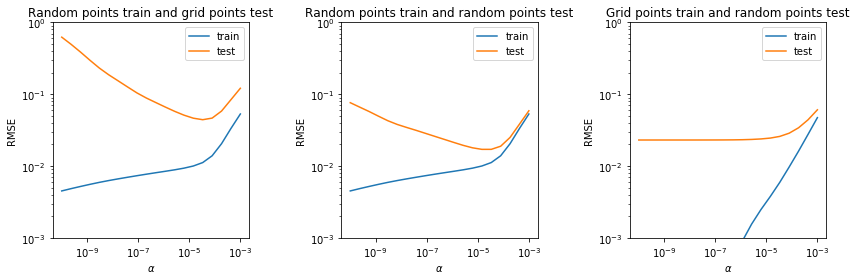

In [16]:
N=5


def plot_err_vs_alpha(X_train, X_test, ax):

    y_train = f21(X_train)
    y_test = f21(X_test)

    mse_train=[]
    mse_test=[]
    alphas=np.power(10, np.linspace(-10, -3, 20))
    for alpha in alphas:
        qsr = QuadraticSplineRegression(knots=[np.linspace(-1,1,3)]*N, alpha=alpha)
        qsr.fit(X_train, y_train)
        mes_1 = np.sqrt(np.square(y_test - qsr.predict(X_test)).mean())
        mes_2 = np.sqrt(np.square(y_train - qsr.predict(X_train)).mean())
        mse_test.append(mes_1+1E-100)
        mse_train.append(mes_2+1E-100)
        

    print("No. of splines ", qsr.N_splines)
    print("No. of training points ", X_train.shape[0])
    
    ax.plot(alphas, mse_train, label="train")
    ax.plot(alphas, mse_test, label="test")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$\alpha$"
                 )
    ax.set_ylabel("RMSE")
    ax.legend()
    ax.set_ylim((10E-4,10E-1))
    return ax


Ngrid = 4
Ndata = Ngrid**N


X_rnd1 = 2 * np.random.rand(Ndata, N) - 1
X_rnd2 = 2 * np.random.rand(Ndata, N) - 1
X_grid = np.zeros((Ngrid**N, N))

x1=np.linspace(-1,1, Ngrid)

c=0
for i in range(Ngrid):
    for j in range(Ngrid):
        for k in range(Ngrid):
            for l in range(Ngrid):
                for m in range(Ngrid):
                    X_grid[c,0] = x1[i]
                    X_grid[c,1] = x1[j]
                    X_grid[c,2] = x1[k]
                    X_grid[c,3] = x1[l]
                    X_grid[c,4] = x1[m]
                    c += 1

fig = plt.figure(figsize=(12,4))
# random input, grid test
ax = plot_err_vs_alpha(X_rnd1, X_grid, ax=fig.add_subplot(1,3,1))                       
ax.set_title("Random points train and grid points test")
# random input, random test
ax = plot_err_vs_alpha(X_rnd1, X_rnd2, ax=fig.add_subplot(1,3,2))
ax.set_title("Random points train and random points test")
# grid input, random test
ax = plot_err_vs_alpha(X_grid, X_rnd2, ax=fig.add_subplot(1,3,3))
ax.set_title("Grid points train and random points test")
plt.tight_layout()
plt.show()

# 嵌套插值回归

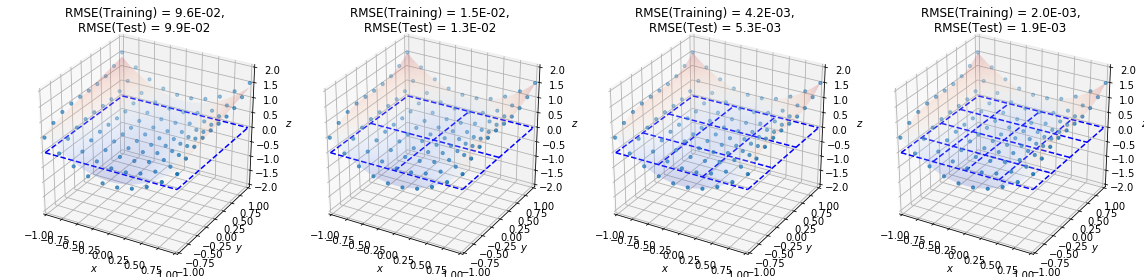

In [17]:
def fit_plot3d_nr(X_train, y_train, knots, X_test=None, y_test=None, xlim=(-1,1), ylim=(-1,1), zlim=(-1,1), ax=None, sz=20, alpha=None):    
    qsrs = [QuadraticSplineRegression(knots=knots) for _ in range(2)]
    reg = NestingRegression(qsrs)
    return fit_plot3d_reg(X_train=X_train, y_train=y_train, reg=reg, knots=knots*2, X_test=X_test, y_test=y_test,\
                          xlim=xlim, ylim=ylim, zlim=zlim, ax=ax, sz=sz)
    

Ndata=4*4
N=2
N_grid=10

X_rnd=2*np.random.rand(Ndata, N)-1

X_grid=np.zeros((N_grid*N_grid, N))
c=0

x1=np.linspace(-1,1,N_grid)
x2=np.linspace(-1,1,N_grid)

for i in range(N_grid):
    for j in range(N_grid):
        X_grid[c,0] = x1[i]
        X_grid[c,1] = x2[j]
        c += 1
        
X_train = X_grid     
y_train = f21(X_train)
X_test = X_rnd
y_test = f21(X_test)


fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1,4,1, projection="3d")
reg = fit_plot3d_nr(X_train = X_train, y_train = y_train, X_test=X_test, y_test=y_test,\
                    zlim=(-2,2), knots=[np.linspace(-1,1,2)], ax=ax1, sz=10)
ax2 = fig.add_subplot(1,4,2, projection="3d")
reg = fit_plot3d_nr(X_train = X_train, y_train = y_train, X_test=X_test, y_test=y_test,\
                    zlim=(-2,2), knots=[np.linspace(-1,1,3)], ax=ax2, sz=10)
ax3 = fig.add_subplot(1,4,3, projection="3d")
reg = fit_plot3d_nr(X_train = X_train, y_train = y_train, X_test=X_test, y_test=y_test,\
                    zlim=(-2,2), knots=[np.linspace(-1,1,4)], ax=ax3, sz=10)
ax4 = fig.add_subplot(1,4,4, projection="3d")
reg = fit_plot3d_nr(X_train = X_train, y_train = y_train, X_test=X_test, y_test=y_test,\
                    zlim=(-2,2), knots=[np.linspace(-1,1,5)], ax=ax4, sz=10)
plt.tight_layout()
plt.show()



# Benchmark

In [12]:
N=5
def f6(X):
    return X[:,0] + X[:,1]**3   \
    + 0.25*1/(1+0.2*X[:,2]) + 0.25*1/(1+0.3*X[:,3])/(1+0.3*X[:,4])


X = 2 * np.random.rand(5*5*8*8*8, N) - 1
y = f6(X) + 0.0 * np.random.randn(5*5*8*8*8)

X_train = X[0::2,:]
y_train = y[0::2] 
X_test = X[1::2,:]
y_test = y[1::2]

mse_train=[]
mse_test=[]

qsr = QuadraticSplineRegression(knots=[np.linspace(-1,1,4)]*N)
%timeit -r1 -n1 qsr.get_H(X_train)
%timeit -r1 -n1 qsr.fit(X_train, y_train)

170 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
13.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
